In [ ]:
import pandas as pd
df = pd.read_pickle('all_scores.pkl')

#Por problemas al guardar las scores cambiamos precision y recall de Rouge
df.rename(columns={'ROUGE1-Precision': 'temp_ROUGE1-Precision', 'ROUGE1-Recall': 'ROUGE1-Precision'}, inplace=True)
df.rename(columns={'temp_ROUGE1-Precision': 'ROUGE1-Recall'}, inplace=True)


df.rename(columns={'ROUGE2-Precision': 'temp_ROUGE2-Precision', 'ROUGE2-Recall': 'ROUGE2-Precision'}, inplace=True)
df.rename(columns={'temp_ROUGE2-Precision': 'ROUGE2-Recall'}, inplace=True)


df.rename(columns={'ROUGEL-Precision': 'temp_ROUGEL-Precision', 'ROUGEL-Recall': 'ROUGEL-Precision'}, inplace=True)
df.rename(columns={'temp_ROUGEL-Precision': 'ROUGEL-Recall'}, inplace=True)

# Cambiamos los nombres de las pipelines
df['methods'] = df['methods'].replace({
    'original': 'Original',
    'original_extracted': 'Extractive',
    'pipeline': 'Recursive',
    'pipeline_extracted': 'Extractive Recursive'
})


print(df.head())
df.to_pickle('all_scores.pkl')


          model_name   methods  ROUGE1-Recall  ROUGE1-Precision  ROUGE1-F1  \
0  google-t5/t5-base  Original       0.089744          0.472973   0.150862   
1  google-t5/t5-base  Original       0.125000          0.378788   0.187970   
2  google-t5/t5-base  Original       0.099379          0.421053   0.160804   
3  google-t5/t5-base  Original       0.106061          0.546875   0.177665   
4  google-t5/t5-base  Original       0.104294          0.500000   0.172589   

   ROUGE2-Recall  ROUGE2-Precision  ROUGE2-F1  ROUGEL-Recall  \
0       0.005141          0.027397   0.008658       0.051282   
1       0.030151          0.092308   0.045455       0.080000   
2       0.015576          0.066667   0.025253       0.062112   
3       0.006079          0.031746   0.010204       0.060606   
4       0.027692          0.134328   0.045918       0.064417   

   ROUGEL-Precision  ROUGEL-F1  BLEU    METEOR  Cosine Similarity  BERTScore  
0          0.270270   0.086207     1  0.046270           0.539461  

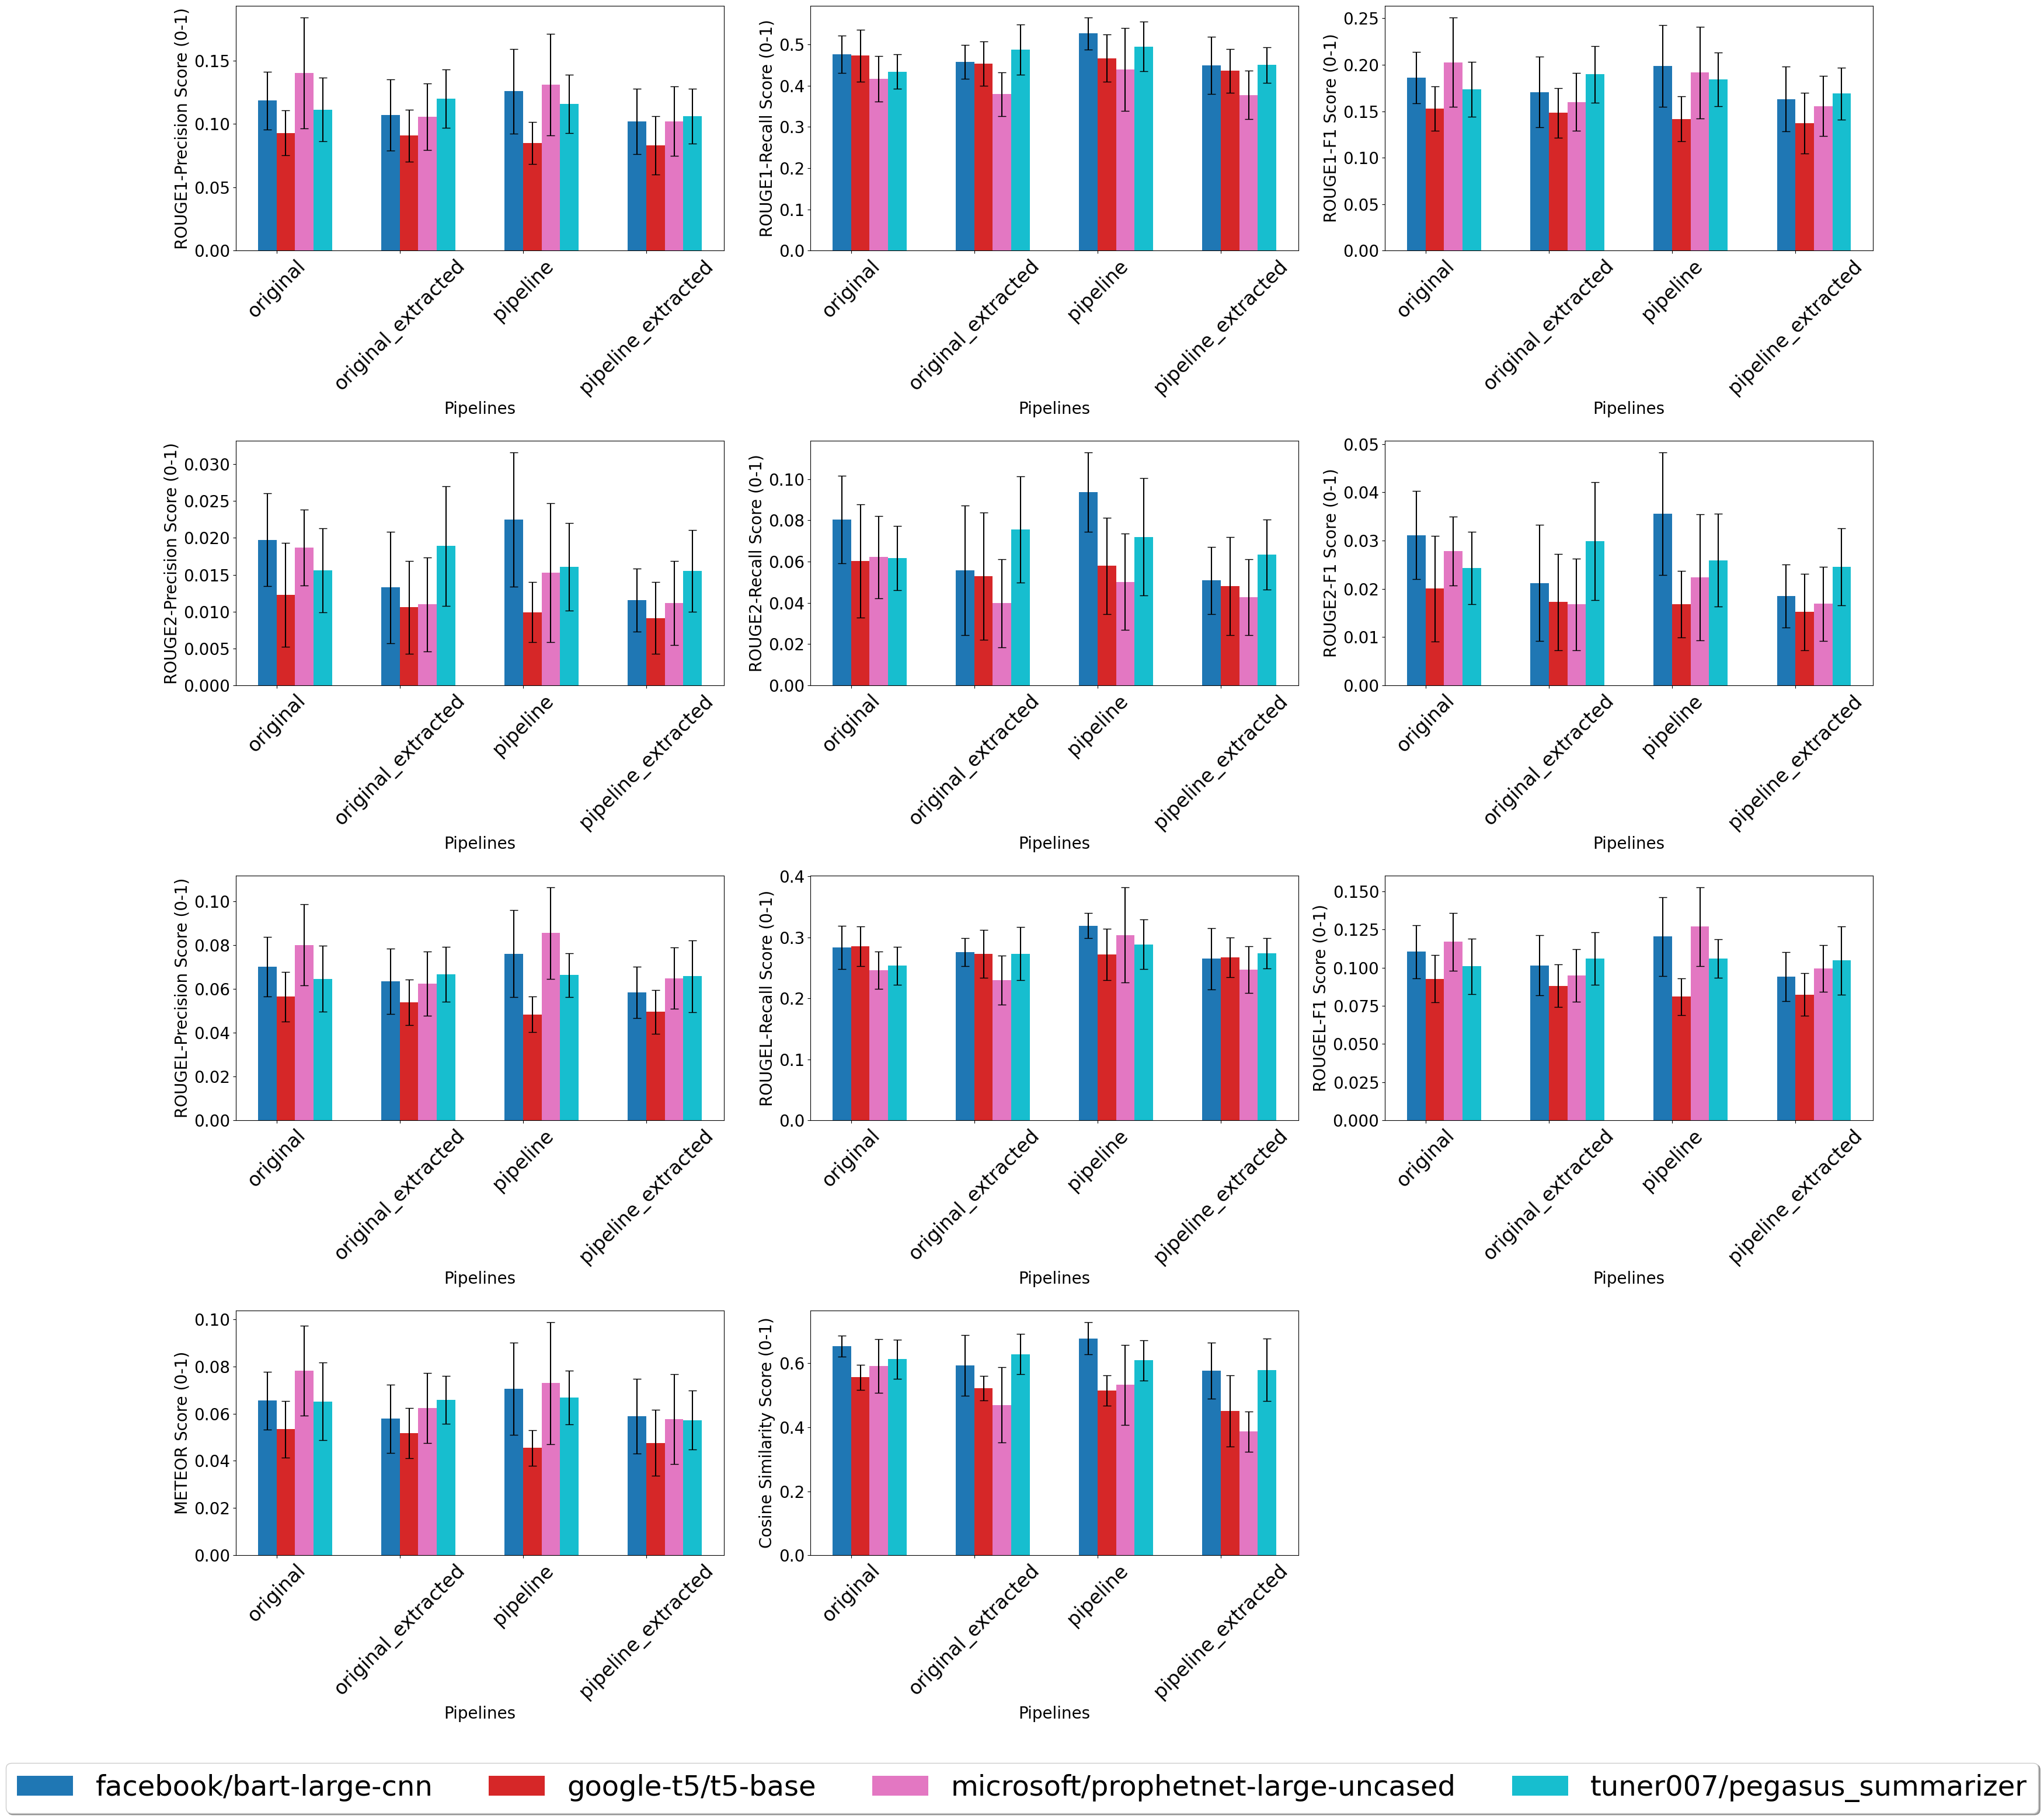

"\n# Comenzamos a hacer el lineplot\nfig, axs = plt.subplots(2, 3, figsize=(45, 30))\nfig.delaxes(axs.flatten()[-1])\naxs = axs.flatten()\n\nfor j, metric in enumerate(metrics):\n    ax = axs[j]\n    lines = []\n    for i, model in enumerate(model_names):\n        model_data = results_df[results_df['model_name'] == model]\n        y = []\n        ci_lower = []\n        ci_upper = []\n\n        for k, method in enumerate(method_names):\n            method_data = model_data[model_data['methods'] == method]\n\n            if len(method_data[metric + '_mean']) > 0:\n                y.append(method_data[metric + '_mean'].values[0])\n                ci_lower.append(method_data[metric + '_bootstrap_ci_lower'].values[0])\n                ci_upper.append(method_data[metric + '_bootstrap_ci_upper'].values[0])\n        line = ax.errorbar(method_names, y, color=colors(i), marker='o', capsize=5)\n        lines.append(line)\n    ax.set_xlabel('Methods')\n    ax.set_ylabel(metric)\n    ax.set_title(f

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.stats as stats
from sklearn.utils import resample


def confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

def bootstrap_confidence_interval(data, num_samples=1000, confidence_level=0.95):
    bootstrap_sample = resample(data, replace=True, n_samples=num_samples)
    lower_bound, upper_bound = confidence_interval(bootstrap_sample)
    return lower_bound, upper_bound

# Cargar datos
all_scores = pd.read_pickle('all_scores.pkl')
metrics = ['ROUGE1-Precision', 'ROUGE1-Recall', 'ROUGE1-F1', 'ROUGE2-Precision', 'ROUGE2-Recall', 'ROUGE2-F1', 'ROUGEL-Precision', 'ROUGEL-Recall', 'ROUGEL-F1', 'METEOR', 'Cosine Similarity']
#reduced metrics
#metrics = ['ROUGE1-F1', 'ROUGE2-F1', 'ROUGEL-F1', 'METEOR', 'Cosine Similarity']


# Calcula intervalo de confianza 95% sin bootstrap
confidence = 0.95
ci = {}
df = pd.DataFrame(all_scores)
#display(df)
grouped_data = df.groupby(["model_name", "methods"])
results_df = pd.DataFrame()

# Itera para cada métrica
for column in df.columns[2:]:

    # Calcula la media
    mean = grouped_data[column].mean()
    results_df[column + '_mean'] = mean

    # Calcula el intervalo de confianza
    ci = grouped_data[column].apply(confidence_interval)
    results_df[column + '_ci_lower'] = ci.apply(lambda x: x[0])
    results_df[column + '_ci_upper'] = ci.apply(lambda x: x[1])

    # Calcula el intervalo de confianza usando bootstrap
    bootstrap_ci = grouped_data[column].apply(bootstrap_confidence_interval)
    results_df[column + '_bootstrap_ci_lower'] = bootstrap_ci.apply(lambda x: x[0])
    results_df[column + '_bootstrap_ci_upper'] = bootstrap_ci.apply(lambda x: x[1])


results_df = results_df.reset_index()

order_dict = {'Original': 0, 'Extractive': 1, 'Recursive': 2, 'Extractive Recursive': 3}
results_df['method_order'] = results_df['methods'].map(order_dict)
results_df.sort_values('method_order', inplace=True)
results_df.drop('method_order', axis=1, inplace=True)


model_names = results_df['model_name'].unique()
method_names = results_df['methods'].unique()

# Creamos el plot
plt.rcParams.update({'font.size': 20})
colors = plt.get_cmap('tab10', len(model_names))


fig, axs = plt.subplots(4, 3, figsize=(30, 30))
fig.delaxes(axs.flatten()[-1])
axs = axs.flatten()

bars = []
for j, metric in enumerate(metrics):
    ax = axs[j]
    bar_width = 0.15
    x = np.arange(len(method_names))

    for i, model in enumerate(model_names):
        model_data = results_df[results_df['model_name'] == model]

        for k, method in enumerate(method_names):
            method_data = model_data[model_data['methods'] == method]

            if len(method_data[metric + '_mean']) > 0:
                y = method_data[metric + '_mean'].values[0]
                lower = method_data[metric + '_ci_lower'].values[0]
                upper = method_data[metric + '_ci_upper'].values[0]
                error = [[y - lower], [upper - y]]
                bar = ax.bar(x[k] + i*bar_width, y, yerr=error, color=colors(i), width=bar_width, capsize=5)
                if k == 0 and j == 0:
                    bars.append(bar)

    ax.set_xlabel('Pipelines')
    ax.set_ylabel(f'{metric} Score (0-1)')
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(method_names, rotation=45, fontsize='large')


fig.legend(bars, model_names, loc='lower center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5, fontsize='xx-large')

plt.tight_layout()
plt.savefig('bar_plots_with_ci.png')
plt.show()


#aqui se puede hacer un lineplot similar
'''
# Inicializamos el lineplot
fig, axs = plt.subplots(2, 3, figsize=(45, 30))
fig.delaxes(axs.flatten()[-1])
axs = axs.flatten()

for j, metric in enumerate(metrics):
    ax = axs[j]
    lines = []
    for i, model in enumerate(model_names):
        model_data = results_df[results_df['model_name'] == model]
        y = []
        ci_lower = []
        ci_upper = []

        for k, method in enumerate(method_names):
            method_data = model_data[model_data['methods'] == method]

            if len(method_data[metric + '_mean']) > 0:
                y.append(method_data[metric + '_mean'].values[0])
                ci_lower.append(method_data[metric + '_bootstrap_ci_lower'].values[0])
                ci_upper.append(method_data[metric + '_bootstrap_ci_upper'].values[0])
        line = ax.errorbar(method_names, y, color=colors(i), marker='o', capsize=5)
        lines.append(line)
    ax.set_xlabel('Methods')
    ax.set_ylabel(metric)
    ax.set_title(f'Line plot of {metric} for different models and methods', fontsize=30)
    if j==0:
      ax.legend(lines, model_names)

plt.rcParams.update({'font.size': 20})
plt.tight_layout()
plt.savefig('line_plots.png')
plt.show()'''



In [1]:
import pandas as pd
from scipy import stats

#Aqui hacemos los calculos para el t test segun los votos de voluntarios

df = pd.read_csv('votos totales.csv')
grouped = df.groupby(['Modelo', 'Metodo'])
stats_df = grouped['Puntuacion'].describe()
stats_df.to_csv("Results.csv")
display(stats_df)

# Filtrar los datos para 'Recursive'
pegasus_pipeline = df[(df['Modelo'].isin(['tuner007/pegasus_summarizer', 'facebook/bart-large-cnn'])) & (df['Metodo'] == 'Recursive')]['Puntuacion']

# Filtrar los datos para el resto
otros = df[(~df['Modelo'].isin(['tuner007/pegasus_summarizer', 'facebook/bart-large-cnn'])) | (df['Metodo'] == 'Recurive')]['Puntuacion']

# Realizar el t-test
t_stat, p_value = stats.ttest_ind(pegasus_pipeline, otros, equal_var=False, nan_policy='omit')

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")


# Filtrar los datos para la pipeline original
Original = df[(~df['Modelo'].isin(['tuner007/pegasus_summarizer', 'facebook/bart-large-cnn'])) | (df['Metodo'] != 'Original')]['Puntuacion']

# Realizar el t-test
t_stat, p_value = stats.ttest_ind(pegasus_pipeline, Original, equal_var=False, nan_policy='omit')

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")


count   mean  \
Modelo                             Metodo                               
facebook/bart-large-cnn            Extractive              8.0  2.250   
                                   Extractive Recursive    8.0  2.000   
                                   Original                8.0  2.500   
                                   Recursive               8.0  2.875   
google-t5/t5-base                  Extractive              2.0  3.000   
                                   Extractive Recursive    2.0  2.000   
                                   Original                2.0  2.500   
                                   Recursive               2.0  2.500   
microsoft/prophetnet-large-uncased Extractive              2.0  2.000   
                                   Extractive Recursive    2.0  2.000   
                                   Original                2.0  2.500   
                                   Recursive               2.0  1.500   
tuner007/pegasus_summarizer        Extractive              8.0  2.750   
                                   Extractive Recursive    8.0  2.125   
                                   Original                8.0  3.125   
                                   Recursive               8.0  3.375   

                                                              std  min   25%  \
Modelo                             Metodo                                      
facebook/bart-large-cnn            Extractive            1.035098  1.0  1.75   
                                   Extractive Recursive  0.925820  1.0  1.00   
                                   Original              1.414214  1.0  1.00   
                                   Recursive             1.125992  1.0  2.00   
google-t5/t5-base                  Extractive            2.828427  1.0  2.00   
                                   Extractive Recursive  1.414214  1.0  1.50   
                                   Original              0.707107  2.0  2.25   
                                   Recursive             2.121320  1.0  1.75   
microsoft/prophetnet-large-uncased Extractive            1.414214  1.0  1.50   
                                   Extractive Recursive  1.414214  1.0  1.50   
                                   Original              2.121320  1.0  1.75   
                                   Recursive             0.707107  1.0  1.25   
tuner007/pegasus_summarizer        Extractive            0.886405  2.0  2.00   
                                   Extractive Recursive  0.991031  1.0  1.75   
                                   Original              1.246423  1.0  2.75   
                                   Recursive             1.407886  1.0  2.75   

                                                         50%   75%  max  
Modelo                             Metodo                                
facebook/bart-large-cnn            Extractive            2.0  3.00  4.0  
                                   Extractive Recursive  2.0  3.00  3.0  
                                   Original              2.5  4.00  4.0  
                                   Recursive             3.0  4.00  4.0  
google-t5/t5-base                  Extractive            3.0  4.00  5.0  
                                   Extractive Recursive  2.0  2.50  3.0  
                                   Original              2.5  2.75  3.0  
                                   Recursive             2.5  3.25  4.0  
microsoft/prophetnet-large-uncased Extractive            2.0  2.50  3.0  
                                   Extractive Recursive  2.0  2.50  3.0  
                                   Original              2.5  3.25  4.0  
                                   Recursive             1.5  1.75  2.0  
tuner007/pegasus_summarizer        Extractive            2.5  3.25  4.0  
                                   Extractive Recursive  2.0  2.25  4.0  
                                   Original              3.0  4.00  5.0  
                                   Recursiv

t-statistic: 1.9028109877684682
p-value: 0.06674142738468548
t-statistic: 1.843345024093855
p-value: 0.07873822279512087


<ipython-input-25-957c25a96451>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Metodo", y="Puntuacion", data=df, palette="rainbow")


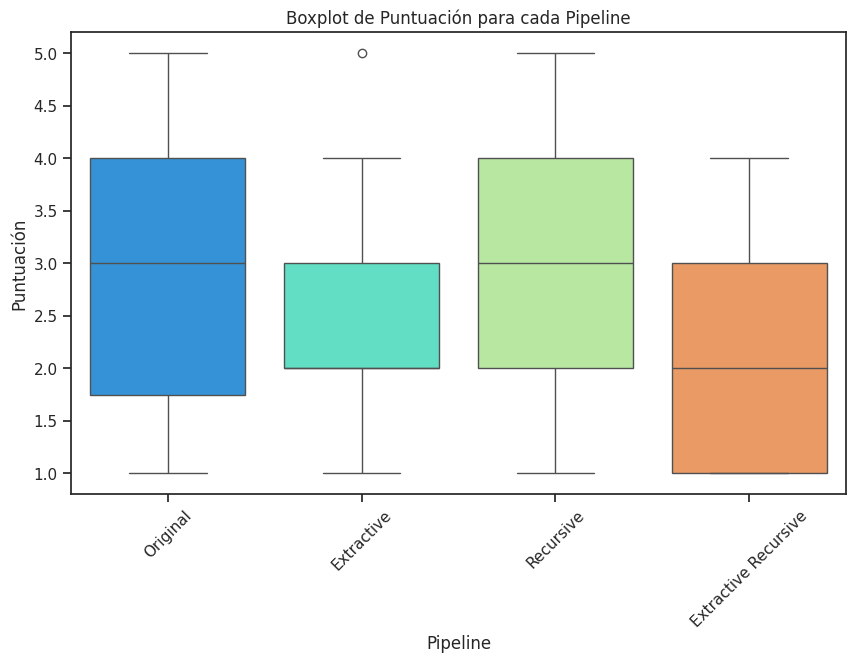

<ipython-input-25-957c25a96451>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Modelo", y="Puntuacion", data=df, palette="rainbow")


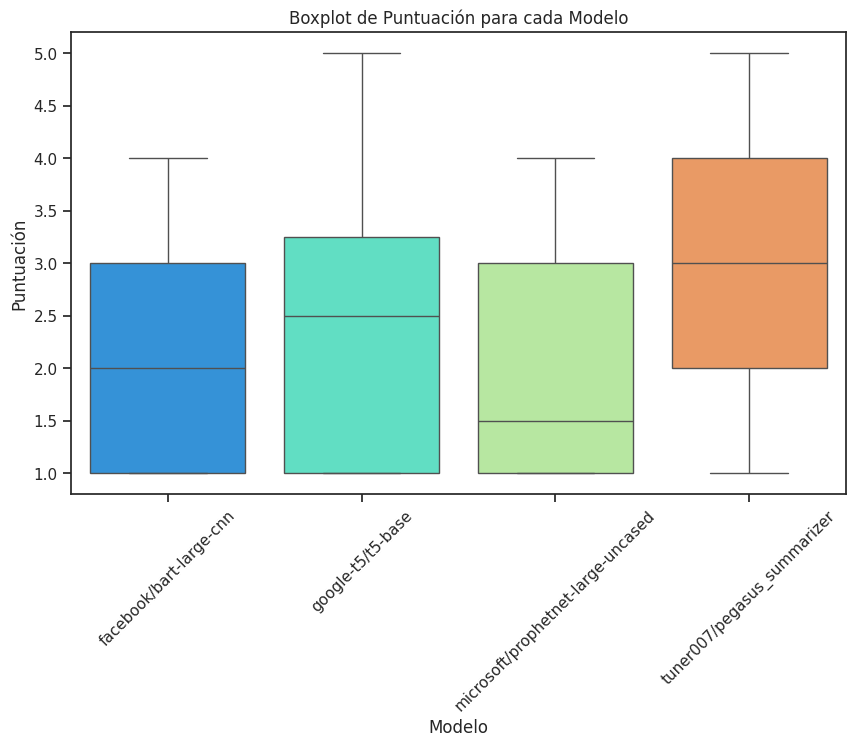

In [25]:
import seaborn as sns


method_names = df['Metodo'].unique()

# Creamos un boxplot con los resultados de la votacion
plt.figure(figsize=(10, 6))
sns.set(style="ticks")

# Crea un boxplot por cada método
order_dict = {'Original': 0, 'Extractive': 1, 'Recursive': 2, 'Extractive Recursive': 3}
df['method_order'] = df['Metodo'].map(order_dict)
df.sort_values('method_order', inplace=True)

ax = sns.boxplot(x="Metodo", y="Puntuacion", data=df, palette="rainbow")

plt.xticks(rotation=45)
plt.title('Boxplot de Puntuación para cada Pipeline')
plt.xlabel('Pipeline')
plt.ylabel('Puntuación')

plt.show()

# Hacemos lo mismo pero para modelos en lugar de methods
plt.figure(figsize=(10, 6))
sns.set(style="ticks")


model_names = df['Modelo'].unique()


order_dict_models = {model: i for i, model in enumerate(sorted(model_names))}
df['model_order'] = df['Modelo'].map(order_dict_models)
df.sort_values('model_order', inplace=True)

ax = sns.boxplot(x="Modelo", y="Puntuacion", data=df, palette="rainbow")

plt.xticks(rotation=45)
plt.title('Boxplot de Puntuación para cada Modelo')
plt.ylabel('Modelo')
plt.ylabel('Puntuación')

plt.show()

